# Warning

The solution notebook took about an hour, in total, to run with the dimension and number of points given below.  You should test this on smaller data sets and give yourself time to run the entire notebook before submitting.

# Project

## Overview
Given a fixed collection of `N` points in $\mathbb{R}^k$, this project consists of implementing algorithms to find the closest point to the input data $y \in \mathbb{R}^k$.
Here closest is measured in the Euclidian norm. 

## Helper Functions

In [2]:
import math
import numpy as np
from scipy import linalg
from scipy import spatial
import time
import matplotlib.pyplot as plt  

run_time_start = time.perf_counter()

# Compute distance between two points 
def distance(x,y):
    return linalg.norm(x-y.reshape(x.shape))



## Solution: Nearest Neighbors - Generating Data

Complete the function `create_column_data` to generate randomly (uniform distribution) `N` points in $\mathbb{R}^k$.  The generated data should be of type `np.array` and have shape `(k, N)`.  Column based data is chosen because the operations we wish to perform on our data will largely use individual points (columns).  **Hint:** The default memory layout for `np.array` is row-major, which means that our column-based operations will need to stride through memory to access the elements of interest, which is not cache-friendly.  When implementing this function pay particular attention to the `order` argument in `np.array`. 

In [3]:

def create_column_data(num_elements, dimension, 
                       lower_bound = -1.0, upper_bound = 1.0):    
    """
    The returned np.array has number of cols=num_elements and number of rows=dimension.
    Each column of the returned object is a data point containing values that 
    fall in the half-open interval [lower_bound, upper_bound).  The memory layout of
    the returned np.array is Fortran order (column major).
    """
    
    return np.array(np.random.uniform(lower_bound, upper_bound, size = (dimension, num_elements)), order = 'F')



### Test Code

Run the following code block to create our input data `X` and a test point `y` using your implementation of `create_column_data`.  `X` should be an `np.array` consisting of 100,000 points in $\mathbb{R}^{1000}$.  

In [4]:

num_elements = 100000
data_dimension = 1000


X = create_column_data(num_elements, data_dimension, -1.0, 1.0)
y = create_column_data(1, data_dimension, -1.0, 1.0)

## Brute Force

This function takes a test point and a data set (where each column is a data point), and exhaustively computes the distance between the test point and every point in the data set.  The point in the data set with minimal distance to the test point should be returned along with its index as a tuple as follows: `(integer, np.array)`, where `integer` can be any integer type, e.g. `np.int64`, and `np.array` is the nearest point.  The `np.array` in the output should have shape `(k,)`.  In the event that multiple points in the data set are equidistant from the test point, you may arbitrarily choose which to return. If either of the passed arguments are `None` then `(None, None)` should be returned.

In [5]:

def nn_brute_force(test_point, data):
    """
    Computes the distance between test_point and every column in data.  The function
    assumes that the number of elements in test_point matches the length of each column
    in data.  The column with minimum distance is returned via a tuple containing the
    index of the column from data and the column itelf with shape modified to match 
    test_point.  Note that this function returns a view of the column from data and not
    a copy.
    """
    if test_point is None or data is None:
        return (None, None)
    test_point = test_point.reshape((test_point.shape[0],))
    dist = 1e+10
    indx = 0
    for i in range(data.shape[1]):
        test_dist = distance(test_point, data[:,i])
        if dist > test_dist:
            dist = test_dist
            indx = i
            continue    
    return (indx, data[:,indx])
        


### Test Code


In [6]:
(idx, nn) = nn_brute_force(y, X)
vec = nn
brute_force_idx = idx
brute_force_distance = distance(y, nn)
print(f'Nearest Neighbor found at index {brute_force_idx} with distance {brute_force_distance}')

Nearest Neighbor found at index 29360 with distance 23.64971168325293


Choose 10 random points from the data set and verify that `nn_brute_force` returns the correct point in each test.  


In [7]:
num_test_points = 10

for i in np.random.choice(num_elements, num_test_points):
    test_point = X[:,i]
    (idx, nn) = nn_brute_force(test_point, X)
    if idx != i:
        if distance(X[:,i], nn) == 0.0:
            print(f'* WARNING: Duplicate data point was found! --OR-- ERROR: Incorrect index returned (wanted {i}, found {idx})')
        else:
            print('* ERROR: Incorrect data point returned for test index', i)
    elif distance(X[:,i], nn) > 0.0:
        print('* ERROR: Incorrect data point returned for test index', i)
    else:
        print(f'TEST {i}: SUCCESS')
        

TEST 85375: SUCCESS
TEST 81172: SUCCESS
TEST 85296: SUCCESS
TEST 18931: SUCCESS
TEST 41368: SUCCESS
TEST 49488: SUCCESS
TEST 36062: SUCCESS
TEST 11279: SUCCESS
TEST 6351: SUCCESS
TEST 36455: SUCCESS


In [8]:
arguments = [[None, X], 
             [y, None],
             [None, None]]

for arg in arguments:
    str_args = [type(a) if a is not None else None for a in arg]
    if nn_brute_force(*arg) != (None, None):
        print(f'TEST ({str_args}): Failed')
    else:
        print(f'TEST ({str_args}): SUCCESS')


TEST ([None, <class 'numpy.ndarray'>]): SUCCESS
TEST ([<class 'numpy.ndarray'>, None]): SUCCESS
TEST ([None, None]): SUCCESS


## kd-trees

This function should create a `scipy.spatial.KDTree` from the passed data and return the tree object.  If the passed data is `None` then `None` should be returned.

In [9]:

def nn_create_kd_tree(data):
    """
    data is a set of column-based points to be spatially sorted into a kd-tree.
    This function returns a scipy.spatial.KDTree object representing data or 
    None if data is None.
    """
    if data is None:
        return None
    return spatial.KDTree(data.T)


This function takes a test_point and a `scipy.spatial.KDTree` as arguments, and queries the tree for the closest point to the test_point.  The point in the tree with minimal distance to the test point should be returned along with its index as a tuple as follows: `(integer, np.array)`, where `integer` can be any integer type, e.g. `np.int64`, and `np.array` is the nearest point.  The `np.array` in the output should have shape `(k,)`.  In the event that multiple points in the data set are equidistant from the test point, you may arbitrarily choose which to return.  If either of the passed arguments are `None` then `(None, None)` should be returned.

In [10]:

def nn_query_kd_tree(test_point, tree):
    """
    Given a test_point and a scipy.spatial.KDTree this function queries the
    kd-tree for the closest point to test_point.  The function returns a tuple
    containing the index of the closest point in the tree along with the 
    closest point itself reshaped to match the shape of test_point.  
    If either argument is None then (None, None) is returned.
    """
    if test_point is None or tree is None:
        return (None, None)
    dist, indx = tree.query(test_point.T)
    vec = tree.data[indx].T
    return (indx, vec)



### Test Code


In [11]:

tree = nn_create_kd_tree(X)
(idx, nn) = nn_query_kd_tree(y, tree)
kdtree_idx = idx
kdtree_distance = distance(y, nn)
print(f'Nearest Neighbor found at index {kdtree_idx} with distance {kdtree_distance}')
if kdtree_distance != brute_force_distance:
    print('Brute Force and KDTree give different results.  Something is amiss.')
else:
    print('Brute Force and KDTree give the same distance.')


Nearest Neighbor found at index [29360] with distance 23.64971168325293
Brute Force and KDTree give the same distance.


Choose 10 random points from the data set and verify that `nn_query_kd_tree` returns the correct point in each test.  


In [12]:

num_test_points = 10

for i in np.random.choice(num_elements, num_test_points):
    test_point = X[:,i]
    (idx, nn) = nn_query_kd_tree(test_point, tree)
    if idx != i:
        if distance(X[:,i], nn) == 0.0:
            print(f'* WARNING: Duplicate data point was found! --OR-- ERROR: Incorrect index returned (wanted {i}, found {idx})')
        else:
            print('* ERROR: Incorrect data point returned for test index', i)
    elif distance(X[:,i], nn) > 0.0:
        print('* ERROR: Incorrect data point returned for test index', i)
    else:
        print(f'TEST {i}: SUCCESS')
        

TEST 95427: SUCCESS
TEST 1701: SUCCESS
TEST 75104: SUCCESS
TEST 5827: SUCCESS
TEST 21329: SUCCESS
TEST 39462: SUCCESS
TEST 97305: SUCCESS
TEST 16432: SUCCESS
TEST 83908: SUCCESS
TEST 60177: SUCCESS


Verify that `(None, None)` is returned if either argument is `None`.

In [13]:
arguments = [[None, tree], 
             [y, None],
             [None, None],
             [y, nn_create_kd_tree(None)]]

for arg in arguments:
    str_args = [type(a) if a is not None else None for a in arg]
    if nn_query_kd_tree(*arg) != (None, None):
        print(f'TEST ({str_args}): Failed')
    else:
        print(f'TEST ({str_args}): SUCCESS')


TEST ([None, <class 'scipy.spatial.kdtree.KDTree'>]): SUCCESS
TEST ([<class 'numpy.ndarray'>, None]): SUCCESS
TEST ([None, None]): SUCCESS
TEST ([<class 'numpy.ndarray'>, None]): SUCCESS


## Performance

In [14]:

num_time_tests = 100
queries = create_column_data(num_time_tests, data_dimension)


In [15]:
# test {num_time_tests} queries using brute force
start = time.perf_counter()
for query in queries.T:
    (idx, nn) = nn_brute_force(query, X)
stop = time.perf_counter()
query_time = stop - start

brute_force_total_time = query_time

print('Brute Force:')
print(f'    Total Query Time: {query_time} seconds')
print(f'    Average Query Time: {query_time/num_time_tests} seconds')
print(f'    Total Time: {brute_force_total_time} seconds')


Brute Force:
    Total Query Time: 70.07050713803619 seconds
    Average Query Time: 0.7007050713803619 seconds
    Total Time: 70.07050713803619 seconds


In [16]:
# test {num_time_tests} queries using kdtree
start = time.perf_counter()
tree = nn_create_kd_tree(X)  
stop = time.perf_counter()
tree_build_time = stop - start

start = time.perf_counter()
for query in queries.T:
    (idx, nn) = nn_query_kd_tree(query, tree)
stop = time.perf_counter()
query_time = stop - start

kdtree_total_time = query_time + tree_build_time

print('KDTreee:')
print(f'    Total Query Time: {query_time} seconds')
print(f'    Average Query Time: {query_time/num_time_tests} seconds')
print(f'    Tree Build Time: {tree_build_time} seconds')
print(f'    Total Time: {kdtree_total_time} seconds')


KDTreee:
    Total Query Time: 69.84060185216367 seconds
    Average Query Time: 0.6984060185216368 seconds
    Tree Build Time: 2.6172071150504053 seconds
    Total Time: 72.45780896721408 seconds


## Approximate Nearest Neighbors - Setup

Complete the function `create_projection_matrix` to create a matrix whose entries are normally distributed.  This matrix will be used to project data generated by `create_column_data` to a lower dimension. 

In [17]:

def create_projection_matrix(n, m): 
    """
    Returns an np.array with n rows and m columns whose values are ranomly sampled
    from a normal distribution (0.0, 1.0).  The memory layout for the returned
    np.array will be row-major.
    """
    return np.array(np.random.normal(0.0, 1.0, size = (n, m)))/math.sqrt(n)
    



### Test Code


In [18]:
# Fix C and epsilon and use Johnson-Lindenstrauss Lemma from the notes to 
# find the smallest reduced dimension (k in the notes)
C = 2.5 # C \in (0,\inf)
epsilon = 0.5 # epsilon \in (0,\inf)
# k >= C log(n) / eps**2, we use ceiling to ensure k is an integer for our map
reduced_dimension = math.ceil(C * math.log(data_dimension) / epsilon**2)

print('Creating map from dimension', data_dimension, 'to', reduced_dimension)
A = create_projection_matrix(reduced_dimension, data_dimension)


Creating map from dimension 1000 to 70


Run the following code blocks to test your brute force and kd-tree implementations on the projected data set.

In [19]:

(idx, nn) = nn_brute_force(A@y, A@X)

reduced_dim_brute_force_distance = distance(y, X[:,idx])
print(f'Reduced Dimension Nearest Neighbor found at index {idx} with distance {reduced_dim_brute_force_distance} in original space')
print(f'Original Nearest Neighbor found at index {brute_force_idx} with distance {brute_force_distance}')



Reduced Dimension Nearest Neighbor found at index 57387 with distance 24.680951617320286 in original space
Original Nearest Neighbor found at index 29360 with distance 23.64971168325293


In [20]:

tree = nn_create_kd_tree(A@X)

(idx, nn) = nn_query_kd_tree(A@y, tree)

reduced_dim_kdtree_distance = distance(y, X[:,idx])
print(f'Nearest Neighbor found at index {idx} with distance {reduced_dim_kdtree_distance} in original space')
print(f'Original Nearest Neighbor found at index {kdtree_idx} with distance {kdtree_distance}')



Nearest Neighbor found at index [57387] with distance 24.680951617320286 in original space
Original Nearest Neighbor found at index [29360] with distance 23.64971168325293


## Performance

Run the following code blocks to time your brute force and kd-tree implementations on the projected data set.

In [21]:
start = time.perf_counter()
reduced_X = A@X
reduced_queries = A@queries
stop = time.perf_counter()
dim_reduct_time = stop - start

start = time.perf_counter()
for query in reduced_queries.T:
    (idx, nn) = nn_brute_force(query, reduced_X)
stop = time.perf_counter()
query_time = stop - start

reduced_dim_brute_force_total_time = query_time + dim_reduct_time

print('Reduced Dimension Brute Force:')
print(f'    Total Query Time: {query_time} seconds')
print(f'    Average Query Time: {query_time/num_time_tests} seconds')
print(f'    Dimension Reduction Time: {dim_reduct_time} seconds')
print(f'    Total Time: {reduced_dim_brute_force_total_time} seconds')

print(f'\nBrute Force Total Time (original dimension): {brute_force_total_time} seconds')



Reduced Dimension Brute Force:
    Total Query Time: 57.02994078793563 seconds
    Average Query Time: 0.5702994078793563 seconds
    Dimension Reduction Time: 0.06326529709622264 seconds
    Total Time: 57.09320608503185 seconds

Brute Force Total Time (original dimension): 70.07050713803619 seconds


In [22]:
start = time.perf_counter()
reduced_X = A@X
reduced_queries = A@queries
stop = time.perf_counter()
dim_reduct_time = stop - start

# test {num_time_tests} reduced queries using kdtree
start = time.perf_counter()
tree = nn_create_kd_tree(reduced_X)  
stop = time.perf_counter()
tree_build_time = stop - start

start = time.perf_counter()
for query in reduced_queries.T:
    (idx, nn) = nn_query_kd_tree(query, tree)
stop = time.perf_counter()
query_time = stop - start

reduced_dim_kdtree_total_time = query_time + tree_build_time + dim_reduct_time

print('Reduced Dimension KDTree:')
print(f'    Total Query Time: {query_time} seconds')
print(f'    Average Query Time: {query_time/num_time_tests} seconds')
print(f'    Tree Build Time: {tree_build_time} seconds')
print(f'    Dimension Reduction Time: {dim_reduct_time} seconds')
print(f'    Total Time: {reduced_dim_kdtree_total_time} seconds')

print(f'\nKDTree Total Time (original dimension): {kdtree_total_time} seconds')


Reduced Dimension KDTree:
    Total Query Time: 43.241621741093695 seconds
    Average Query Time: 0.43241621741093694 seconds
    Tree Build Time: 0.8915565290953964 seconds
    Dimension Reduction Time: 0.07099281996488571 seconds
    Total Time: 44.20417109015398 seconds

KDTree Total Time (original dimension): 72.45780896721408 seconds


## Distortion

The distortion is computed as the $\max_i \frac{\|f(X_i)\|_2}{\|X_i\|_2} \cdot \max_i \frac{\|X_i\|_2}{\|f(X_i)\|_2}$, where $f(X_i) = AX_i$ is the projection $X_i$, the ith column of `X`.




In [23]:

def compute_distortion(X, T_X):
    """
    Computes and returns the distortion between the set of data points (columns in x)
    and their image (columns in T_x).  The distortion is computed as 
    max_{i \ne j} (|| T_X_i - T_X_j || / || X_i - X_j ||) * max_{i \ne j} (|| X_i - X_j || / || T_X_i - T_X_j ||)
    , where T_X_i and X_i are the
    ith columns of T_X and X, respectively and max_i is the max over all i.  Also, ||a|| 
    here refers to the L2 norm.
    """
    maximum = 0
    minimum = 1e+10
    for i in range(1,X.shape[1]):
        for j in range(i):
            Ratio = distance(T_X[:,i],T_X[:,j])/distance(X[:,i],X[:,j])
            if Ratio>maximum:
                maximum = Ratio
            if Ratio<minimum:
                minimum = Ratio
    return maximum/minimum


### Test Code



In [24]:

reduced_X = A@X

subset_size = min(1000, num_elements)
subset_elements = np.random.choice(num_elements, subset_size, replace=False)

map_distortion = compute_distortion(X[:,subset_elements], reduced_X[:,subset_elements])
print('map_distortion =', map_distortion)
print(f'{map_distortion} <= {(1 + epsilon) / (1 - epsilon)}')
if map_distortion <= (1 + epsilon) / (1 - epsilon):
    print(f'  The linear map, A, satifies the theoretical bound.')
else:
    print(f'  The linear map, A, does not satisfy the theoretical bound.')



map_distortion = 2.2050616883874166
2.2050616883874166 <= 3.0
  The linear map, A, satifies the theoretical bound.


## Iteration

Even if the distortion imposed by the linear map is small the resulting nearest neighbor in the reduced space may not be the nearest neighbor in the original space.  This can be seen by running many instances of random projections and comparing their results.

  



In [25]:
def iterate_reduced_nn(X, y, reduced_dimension, num_trials=10):
    """
    This function performs a number of nearest neighbor trials, each of which 
    consists of the projection of the input data set x and test point y to a 
    lower dimension and the nearest neighbor of the test point is sought in 
    the data set (in the lower dimension).  The nearest neighbor computation 
    will be performed by first creating a scipy.spatial.KDTree with the 
    projected x and then querying it using the projected y.  The index of each
    identified nearest neighbor will be added to a list and only the unique
    indices returned (no duplicates).
    
    X - A column based data set from which the nearest neighbor to y is sought
    y - A test point with length equal to column length of X, which is to be used
        as a query point
    reduced_dimension - An integer representing the dimension of the reduced space
        in which the nearest neighbor computation will be performed.
    num_trials - The number of projection matrices to be tested.
    """
    unique_indices = []
    for num_trial in range(num_trials):
        A = create_projection_matrix(reduced_dimension,y.shape[0])
        tree = nn_create_kd_tree(A@X)
        (idx, nn) = nn_query_kd_tree(A@y, tree)
        unique_indices.append(idx[0])    
    return list(set(unique_indices))
        


In [26]:
possible_solutions = iterate_reduced_nn(X, y, reduced_dimension)

print(f'{len(possible_solutions)} different solutions found.')

10 different solutions found.


In [27]:

def nn_iterative(X, y, reduced_dimension, num_trials=10):
    """
    Perfrom a number of approximate nearest neighbor trials in a reduced space. 
    The results of those trials are used to select a subset of the data points in 
    X and repeat the nearest neighbor computation in the original dimension using
    only the selected data points.  The function returns a tuple containing the 
    index of the nearest neighbor in the original data set along with the nearest 
    neighbor itself reshaped to match the shape of test_point. 
    
    X - A column based data set from which the nearest neighbor to y is sought
    y - A test point with length equal to column length of X, which is to be used
        as a query point
    reduced_dimension - An integer representing the dimension of the reduced space
        in which the nearest neighbor computation will be performed.
    num_trials - The number of projection matrices to be tested.
    """
    indices = iterate_reduced_nn(X, y, reduced_dimension, num_trials)
    tree = nn_create_kd_tree(X[:,indices])
    (idx, nn) = nn_query_kd_tree(y, tree)
    return (indices[idx], nn.reshape(y.shape))    
    
    


### Test Code


In [28]:

(idx, nn) = nn_iterative(X, y, reduced_dimension)

iterative_distance = distance(y, nn)
print(f'Nearest Neighbor found at index {idx} with distance {iterative_distance}')
if iterative_distance != brute_force_distance:
    print(f'Brute Force and Iterative give different results.  Brute Force distance = {brute_force_distance}')
else:
    print('Brute Force and Iterative give the same distance.')



Nearest Neighbor found at index [8] with distance 25.00154605367263
Brute Force and Iterative give different results.  Brute Force distance = 23.64971168325293


In [29]:

max_num_iterations = math.ceil(math.log(num_elements,2))

iteration_based_distances = []
for n in range(1,max_num_iterations+1):
    (idx, nn) = nn_iterative(X, y, reduced_dimension, n)
    iteration_based_distances.append(distance(y, nn))



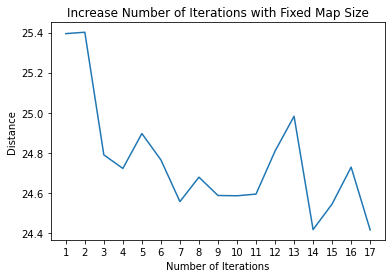

In [30]:
plt.plot(iteration_based_distances)
plt.title('Increase Number of Iterations with Fixed Map Size')
plt.xticks(range(max_num_iterations), range(1,max_num_iterations+1))
plt.xlabel('Number of Iterations')
plt.ylabel('Distance')
plt.show()    


## Choice of Dimension


In [31]:

max_reduced_dimension = 500
step_size = 10

dimension_based_distances = []
for n in range(10,max_reduced_dimension+1, step_size):
    (idx, nn) = nn_iterative(X, y, n, 1)
    dimension_based_distances.append(distance(y, nn))

    


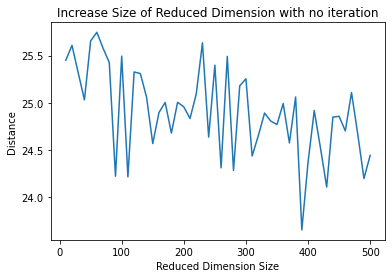

In [32]:
plt.plot(range(10,max_reduced_dimension+1, step_size),dimension_based_distances)
plt.title('Increase Size of Reduced Dimension with no iteration')
plt.xlabel('Reduced Dimension Size')
plt.ylabel('Distance')
plt.show()    


## Iteration vs Dimension

Run the given code blocks to compute the distances of the nearest neighbors generated with your implementation of `nn_iterative` using projections of varying size with varying numbers of iterations.

In [33]:

iteration_based_distances_10 = []
for n in range(1,max_num_iterations+1):
    (idx, nn) = nn_iterative(X, y, 10, n)
    iteration_based_distances_10.append(distance(y, nn))

iteration_based_distances_500 = []
for n in range(1,max_num_iterations+1):
    (idx, nn) = nn_iterative(X, y, 500, n)
    iteration_based_distances_500.append(distance(y, nn))   


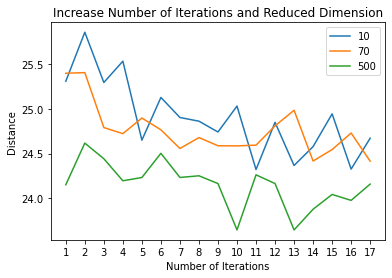

In [34]:

plt.plot(iteration_based_distances_10)
plt.plot(iteration_based_distances) # computed in Iteration section
plt.plot(iteration_based_distances_500)

plt.title('Increase Number of Iterations and Reduced Dimension')
plt.xticks(range(max_num_iterations), range(1,max_num_iterations+1))
plt.xlabel('Number of Iterations')
plt.ylabel('Distance')
plt.legend(['10', f'{reduced_dimension}', '500'])
plt.show()    
